In [1]:
import os
import yaml
import time
import numpy as np
import pandas as pd
from pathlib import Path
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.patches import Circle

In [2]:
with open("Star_Configurations/current_config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

# Example access:
print(cfg["main_star"])

UCAC4 754-046742


In [3]:
base_dir = Path(cfg["base_dir"])
print("base_dir = "+str(base_dir))

file_object = cfg["file_object"]
print("file_object = "+str(file_object))

main_star = cfg["main_star"]
print("main_star = "+main_star)


file_nights = cfg["file_nights"].keys()
file_nights = list(file_nights)
print("file_nights = "+str(file_nights))

master_filter = cfg["master_colour"]
print("master_filter =", master_filter)

base_dir = data
file_object = Standards_1
main_star = UCAC4 754-046742
file_nights = ['2024_03_05']
master_filter = Bader_JC_R


In [4]:
# Define paths
fits_path = base_dir / file_object / master_filter / "clipped_mean_image.fits"
photometry_path = base_dir / file_object / master_filter / "clipped_mean_image_photometry_solved_normilsation.csv"

# Normilsation_star

# Read photometry data
photometry_data = pd.read_csv(photometry_path)
photometry_data = photometry_data[photometry_data['Normilsation_star'] == True]

# Load FITS image
with fits.open(fits_path) as hdul:
    fits_master = hdul[0].data

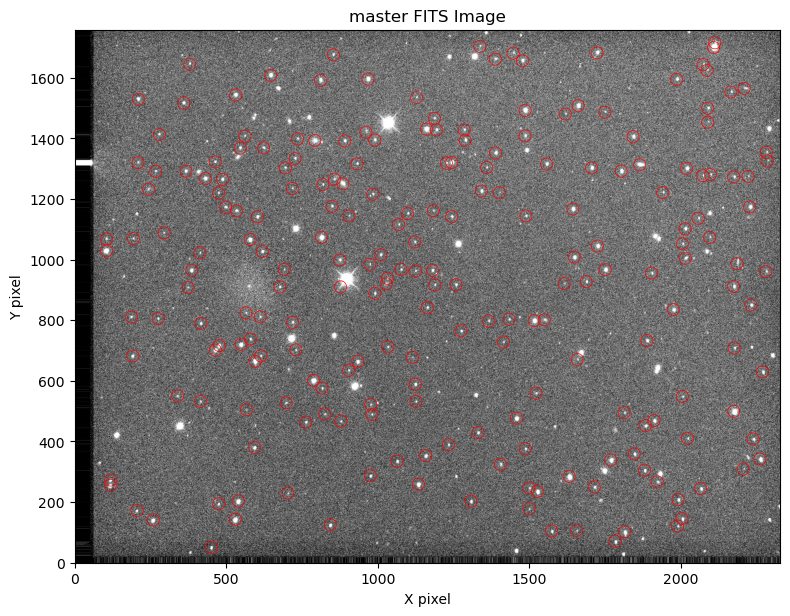

In [5]:
# Plot FITS image
plt.figure(figsize=(8, 8))
plt.imshow(fits_master, cmap='gray', origin='lower',
           vmin=np.percentile(fits_master, 5),
           vmax=np.percentile(fits_master, 99))
plt.title("master FITS Image")
plt.xlabel("X pixel")
plt.ylabel("Y pixel")

# Overlay star positions as red circles - 
# just stars that can be used for normilsation as they've been checked for bg and neighbours
for _, row in photometry_data.iterrows():
    x, y = row['xcenter'], row['ycenter']
    circ = Circle((x, y), radius=20, edgecolor='red', facecolor='none', linewidth=0.5)
    plt.gca().add_patch(circ)

plt.tight_layout()
plt.show()

In [6]:
# Define a 1D Gaussian function for curve fit
def gaussian(x, amp, mean, sigma, offset):
    return amp * np.exp(-(x - mean)**2 / (2 * sigma**2)) + offset

In [7]:
def analyse_star(star_num, unit='pixel', plotting=True):

    # Get the star's coordinates (example: first star in filtered DataFrame)
    x = int(photometry_data.iloc[star_num]['xcenter'])
    y = int(photometry_data.iloc[star_num]['ycenter'])

    # Define slice ranges (±10 pixels)
    x_range = slice(x - 15, x + 16)
    y_range = slice(y - 15, y + 16)

    # Horizontal slice: fixed y, vary x
    horizontal_slice = fits_master[y, x_range]
    x_pixels = np.arange(x - 15, x + 16)

    # Fit Gaussian to horizontal slice
    initial_guess_h = [horizontal_slice.max(), x, 2.0, np.median(horizontal_slice)]
    popt_h, _ = curve_fit(gaussian, x_pixels, horizontal_slice, p0=initial_guess_h)

    # Generate fitted curve for horizontal slice
    x_fit = np.linspace(x - 15, x + 16, 200)
    y_fit_h = gaussian(x_fit, *popt_h)

    # Offset - difference between gaussian and photometry centroid (not sure if its useful but it's here now)
    offset_h = abs(popt_h[1] - x)

    # Plot horizontal slice
    if plotting:
        plt.figure(figsize=(10, 4))
        plt.plot(x_pixels, horizontal_slice, linestyle='none', marker='o', label='Data')
        plt.plot(x_fit, y_fit_h, 'r-', label='Gaussian fit')
        plt.axvline(x, color='k', linestyle='--', label=f'Photometry centroid = {x:.2f}')
        plt.axvline(popt_h[1], color='purple', linestyle='--', label=f'Gaussian centroid = {popt_h[1]:.2f}')
        plt.title(f"Star = {star_num}: Horizontal slice +/- 15 pixels at y = {y}")
        plt.xlabel("X pixel position")
        plt.ylabel("Pixel value")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Vertical slice: fixed x, vary y
    vertical_slice = fits_master[y_range, x]
    y_pixels = np.arange(y - 15, y + 16)

    # Fit Gaussian to vertical slice
    initial_guess_v = [vertical_slice.max(), y, 2.0, np.median(vertical_slice)]
    popt_v, _ = curve_fit(gaussian, y_pixels, vertical_slice, p0=initial_guess_v)

    # Generate fitted curve for vertical slice
    y_fit = np.linspace(y - 15, y + 16, 200)
    x_fit_v = gaussian(y_fit, *popt_v)

    # Offset
    offset_v = abs(popt_v[1] - y)

    # Plot vertical slice
    if plotting:
        plt.figure(figsize=(10, 4))
        plt.plot(y_pixels, vertical_slice, linestyle='none', marker='o', label='Data')
        plt.plot(y_fit, x_fit_v, 'r-', label='Gaussian fit')
        plt.axvline(y, color='k', linestyle='--', label=f'Photometry centroid = {y:.2f}')
        plt.axvline(popt_v[1], color='purple', linestyle='--', label=f'Gaussian centroid = {popt_v[1]:.2f}')
        plt.title(f"Star = {star_num}: Vertical slice +/-15 pixels at x = {x}")
        plt.ylabel("Y pixel position")
        plt.xlabel("Pixel value")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # FWHM
    fwhm_h = 2 * np.sqrt(2 * np.log(2)) * popt_h[2]    # Horizontal FWHM
    fwhm_v = 2 * np.sqrt(2 * np.log(2)) * popt_v[2]    # Vertical FWHM
    mean_fwhm = (fwhm_v + fwhm_h) / 2

    # Roundness
    amp_x = popt_h[0]  # amplitude from horizontal fit
    amp_y = popt_v[0]  # amplitude from vertical fit
    roundness = abs((amp_y - amp_x) / ((amp_y + amp_x) / 2))

    # Conversion to arcseconds
    if unit == 'arcsecond':
        arcsec_per_pix = 0.49  # From Phys. Educ. 58 (2023) 035014 (13pp) 
        mean_fwhm *= arcsec_per_pix
        offset_h *= arcsec_per_pix
        offset_v *= arcsec_per_pix

    # Return results
    return mean_fwhm, roundness, offset_h, offset_v
    

In [8]:
stars_fwhm = []
stars_roundness = []
stars_offset_h, stars_offset_v = [], []

unit = 'pixel'   # Either pixel or arcsecond

for i in range(len(photometry_data)):
    fwhm, roundness, offset_h, offset_v = analyse_star(i, unit=unit, plotting=False)
    stars_fwhm.append(fwhm)
    stars_roundness.append(roundness)
    stars_offset_h.append(offset_h)
    stars_offset_v.append(offset_v)

In [9]:
# Calc means
mean_fwhm = np.mean(stars_fwhm)
mean_roundness = np.mean(stars_roundness)

mean_offset_h = np.mean(stars_offset_h)
mean_offset_v = np.mean(stars_offset_v)

print(f"Mean FWHM: {mean_fwhm:.4f} {unit}s")
print(f"Mean roundness: {mean_roundness:.4f}")

# Again not sure how useful these are but it's here now
print(f"\nMean horizontal offset: {mean_offset_h:.2f} {unit}s")
print(f"Mean vertical offset: {mean_offset_v:.2f} {unit}s")

Mean FWHM: 4.5443 pixels
Mean roundness: 0.1276

Mean horizontal offset: 0.52 pixels
Mean vertical offset: 0.53 pixels
